## This notebook is used to analyze and summarize the questions response from the LLM model

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# first of all get the total number of each policies
with open("../output/otago_policies_20250223233950.json", "r") as f:
    data = json.load(f)

policy_types = []
policy_counts = []
policy_contents_words = []
for item in data:
    policy_types.append(item)
    policy_counts.append(len(data[item]))
    policy_contents_words.append(
        sum([len(policy["content"].split()) for policy in data[item]])
    )

df = {
    "policy_types": policy_types,
    "policy_counts": policy_counts,
    "policy_contents_words": policy_contents_words,
}
df = pd.DataFrame(df)
df

,policy_types,policy_counts,policy_contents_words
0,Guidelines,54,57221
1,Plans & Strategies,2,8
2,Policies,119,111167
3,Procedures,61,62908
4,Regulations,9,9627
5,Statutes,11,16949


C:\Users\chris\AppData\Local\Temp\ipykernel_27476\4101573331.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df["policy_types"], rotation=45, ha="right")


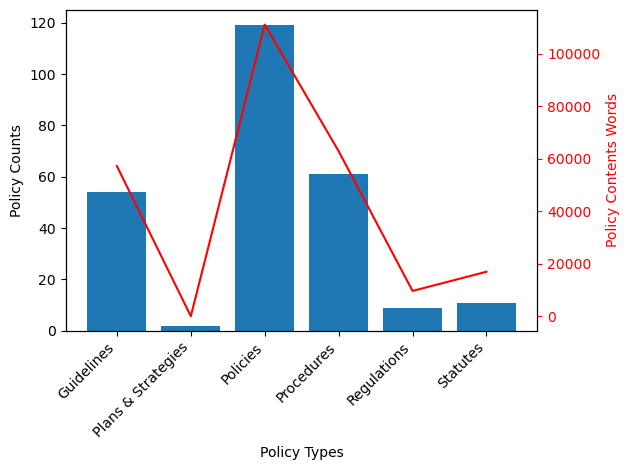

In [2]:
# plot policy_counts in bar chart while policy_contents_words in line chart
fig, ax1 = plt.subplots()
ax1.bar(df["policy_types"], df["policy_counts"])
ax1.set_xlabel("Policy Types")
ax1.set_ylabel("Policy Counts")
ax1.tick_params("y")
ax1.set_xticklabels(df["policy_types"], rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(df["policy_types"], df["policy_contents_words"], color="r")
ax2.set_ylabel("Policy Contents Words", color="r")
ax2.tick_params("y", colors="r")

fig.tight_layout()
plt.show()


**Question One:** Please list all policies that contain unnecessary content such as cross-references to other policies (there's a space for this in the policy documents, but not in the words of the policy itself)?

**Question Two:** Please list all policies that contain parts that are actually Procedures, not Policies (e.g. they contain instructions on how to do something, rather than rules or principles)?

**Question Three:** Please list all policies that contain inconsistencies or structural flaws. For example, if a policy is missing a section that is present in other policies, or if a policy has a section that is not relevant to the policy type?"

**Question Four:** Please list all redundancy or incorrect structure of policy. It could be that there's a better way to structure the policy database, or that some policies are redundant or overlapping?"


In [3]:
# Load Policies_llama3_2.json into a python object

with open ('Policies_llama3_2_updated.json', 'r') as f:
    policies = json.load(f)

In [4]:
# create a bar chart of number of response types in each questions

# read the policies into a pandas dataframe
df = pd.DataFrame(policies)
# only select "q1_consistence", "q2_consistence", "q3_consistence" and "q4_consistence"
df = df[["q1_consistence", "q2_consistence", "q3_consistence", "q4_consistence"]]
# count the number of each response type in each question
df = df.apply(pd.Series.value_counts)
df

,q1_consistence,q2_consistence,q3_consistence,q4_consistence
CONSISTENT,48,79,29.0,41.0
INCONSISTENT,70,38,90.0,78.0
Not Applicable,1,2,NaN,NaN


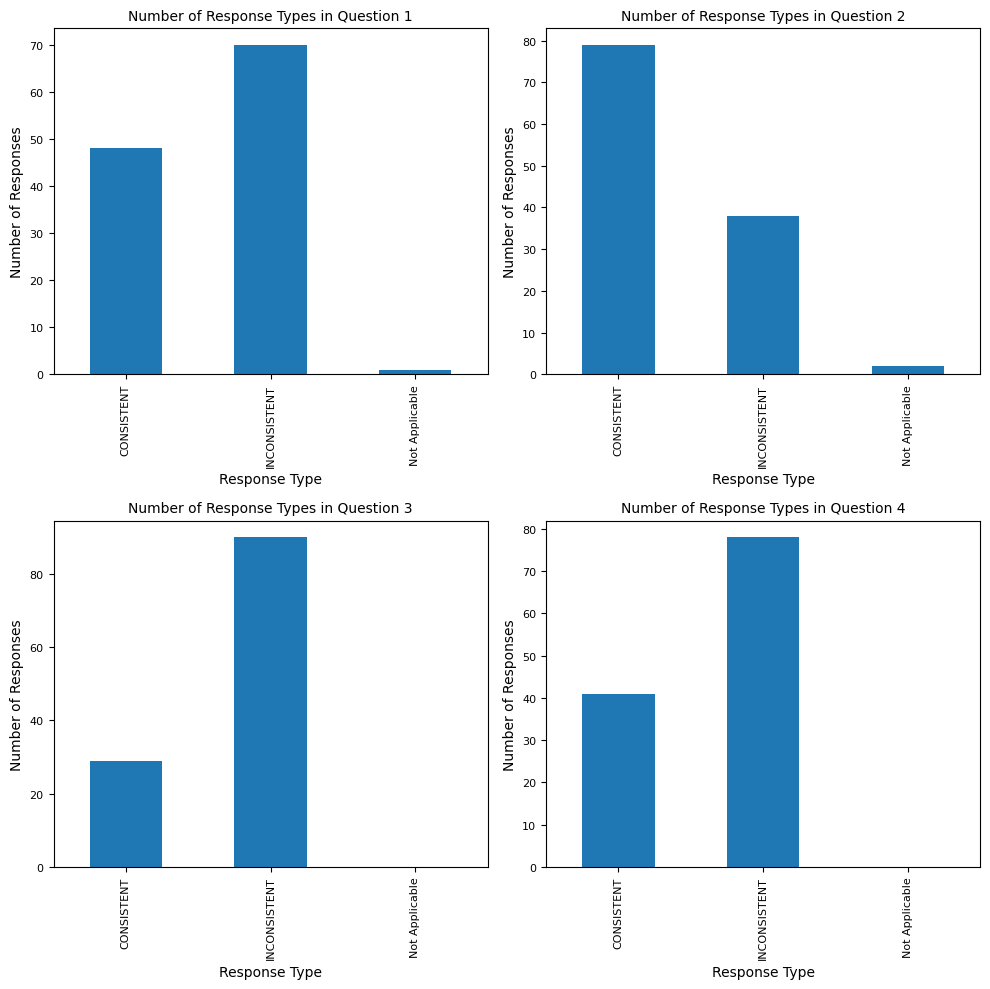

In [5]:
# plot each question question response consistence in a bar chart with 4 sub plots
for question in range(1, 5):
    if f'q{question}_consistence' in df.columns:
        plt.subplot(2, 2, question)
        ax = df[f'q{question}_consistence'].plot(kind='bar')
        ax.set_xlabel("Response Type")
        ax.set_ylabel("Number of Responses")
        ax.set_title(f"Number of Response Types in Question {question}")
        #change lable and title font size
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.title.set_size(10)
        

# change main plt size to larger
plt.gcf().set_size_inches(10, 10)
# add padding between subplots
plt.tight_layout()
# show the plot
plt.show()
        


In [6]:
# summarize number of constant and inconsistent responses in each question
df = pd.DataFrame(policies)
df = df[["name","q1_consistence", "q2_consistence", "q3_consistence", "q4_consistence"]]
# count number of inconsistent responses in each question
df['num_inconsistent'] = df[['q1_consistence','q2_consistence','q3_consistence','q4_consistence']].eq('INCONSISTENT').sum(axis=1)
df['num_consistent'] = df[['q1_consistence','q2_consistence','q3_consistence','q4_consistence']].eq('CONSISTENT').sum(axis=1)
df['consistent_rate'] = df['num_consistent'] / 4
df = df[['name','num_inconsistent','num_consistent','consistent_rate']]
# generate the top 10 most consistent responses
df = df.sort_values(by='num_consistent', ascending=False)
df.head(10)

,name,num_inconsistent,num_consistent,consistent_rate
16,Parental_Leave_Policy,0,4,1.0
54,Child_Protection_Policy,0,4,1.0
30,Emergency_Management_Policy,0,4,1.0
29,Closed_Circuit_Television_CCTV_Security_System...,0,4,1.0
28,Treasury_Management_Policy,0,4,1.0
25,Information_and_Records_Management_Policy,0,4,1.0
87,Student_Critical_Incident_Policy,0,4,1.0
46,Ethical_Behaviour_Policy,0,4,1.0
93,Administration_of_Final_Examinations_Policy,0,4,1.0
15,Performance_Development_Review_Policy,0,4,1.0


In [7]:
# generate the top 10 most inconsistent responses
df = df.sort_values(by='num_inconsistent', ascending=False)
df.head(10)

,name,num_inconsistent,num_consistent,consistent_rate
0,Equal_Employment_Opportunities_Policy,4,0,0.0
101,Initial_Teacher_Education_Professional_Standar...,4,0,0.0
52,Carry_Forward_Balances_Policy,4,0,0.0
41,Web_Policy,4,0,0.0
6,Fraud_Policy,4,0,0.0
108,Smoke_free_Policy,4,0,0.0
42,Policy_for_the_Award_of_the_Title_of_Emeritus_...,4,0,0.0
78,Information_Security_Policy,4,0,0.0
60,Health_and_Safety_Approved_Contractors_Policy,4,0,0.0
8,Papers_Enrolments_and_the_Use_of_Resources_Policy,4,0,0.0


In [8]:
# summarize number of policies by different consistent rate
df['consistent_rate'] = df['consistent_rate'].apply(lambda x: round(x, 2))
df = df.groupby('consistent_rate').count()


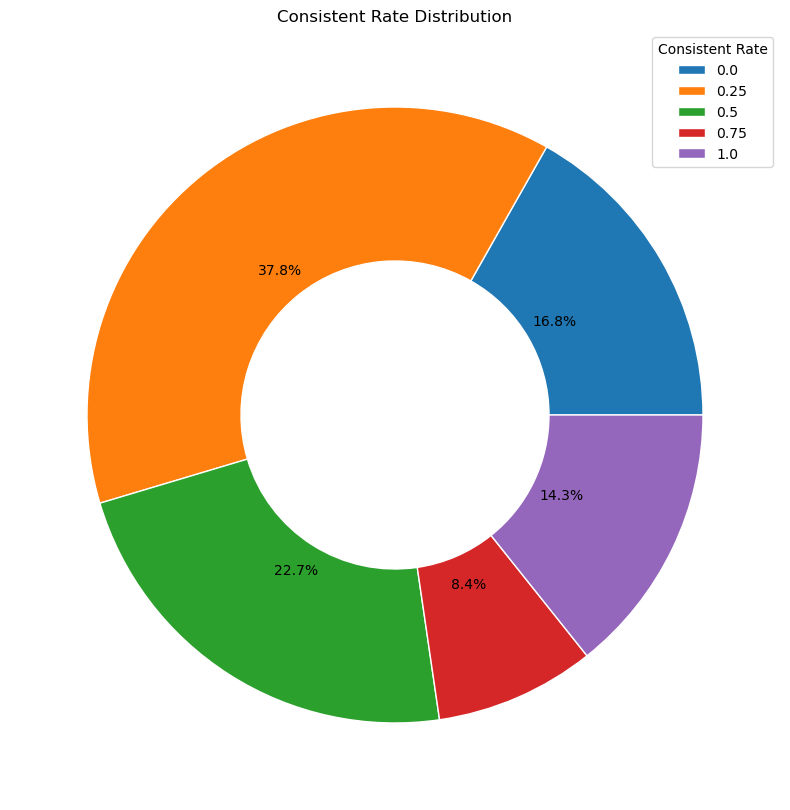

In [9]:
# plot consistent rate distribution in pie chart and print value
size = 0.5
plt.pie(df["num_consistent"], autopct="%1.1f%%", radius=1, wedgeprops=dict(width=size, edgecolor='w'))
plt.title("Consistent Rate Distribution")
# set legend description as Consistent Rate
plt.legend(df.index, title="Consistent Rate", loc="upper right")
# change the plot size to larger
plt.gcf().set_size_inches(10, 10)
plt.show()


## The codes below investigating policy metadata completeness

In [10]:
total_policies = 0
policy_type_counts = 0
approved_by_counts = 0
date_polcy_counts = 0
date_approved_counts = 0
sponsor_counts = 0
responsible_counts = 0


# import beautifulsoup
from bs4 import BeautifulSoup


for policy_type in data:
    for policy in data[policy_type]:
        total_policies += 1
        file_path = "." + policy["url"]
        # file_path = '../output/html/Guidelines/Academic_Staff_Recruitment_Process_Guidelines.html'
        # open html file from file path
        with open(file_path, "r") as f:
            html = f.read()
            soup = BeautifulSoup(html, "html.parser")
            # Extract first column values (th elements)
            ths = soup.find_all("th")
            for th in soup.find_all("th"):
                # check  if either Category, Type, Approved by, Date Guideline Took Effect, Last approved revision, Sponsor or Responsible Office is in the th element

                if "category" in th.get_text(strip=True).lower():
                    policy_type_counts += 1
                if "approved by" in th.get_text(strip=True).lower():
                    approved_by_counts += 1
                if "took effect" in th.get_text(strip=True).lower():
                    date_polcy_counts += 1
                if "last approved revision" in th.get_text(strip=True).lower():
                    date_approved_counts += 1
                if "sponsor" in th.get_text(strip=True).lower():
                    sponsor_counts += 1
                if "responsible office" in th.get_text(strip=True).lower():
                    responsible_counts += 1

        # Create metadata_completeness dataframe and structure_consistency dataframe

metadata_completeness = {
    "Metadata Field": [
        "Policy Type",
        "Approved By",
        "Date Policy Took Effect",
        "Last Approved Revision",
        "Sponsor",
        "Responsible Office",
    ],
    "Completeness Rate": [
        round(policy_type_counts / total_policies * 100, 0),
        round(approved_by_counts / total_policies * 100, 0),
        round(date_polcy_counts / total_policies * 100, 0),
        round(date_approved_counts / total_policies * 100, 0),
        round(sponsor_counts / total_policies * 100, 0),
        round(responsible_counts / total_policies * 100, 0),
    ],
    "Compliance Status": [
        "Non-Compliant" if x < 0.75
        else ("Compliant" if x >= 1.0 else "Partially Compliant")
        for x in [
            policy_type_counts / total_policies,
            approved_by_counts / total_policies,
            date_polcy_counts / total_policies,
            date_approved_counts / total_policies,
            sponsor_counts / total_policies,
            responsible_counts / total_policies,
        ]
    ],
}

df_metadata_completeness = pd.DataFrame(metadata_completeness)
df_metadata_completeness



,Metadata Field,Completeness Rate,Compliance Status
0,Policy Type,100.0,Compliant
1,Approved By,100.0,Compliant
2,Date Policy Took Effect,100.0,Compliant
3,Last Approved Revision,100.0,Compliant
4,Sponsor,100.0,Compliant
5,Responsible Office,100.0,Partially Compliant


In [11]:


structural_consistency = []

for policy_type in data:
    purpose_counts = 0
    scope_counts = 0
    content_counts = 0
    total_policies = 0
    for policy in data[policy_type]:
        total_policies += 1
        file_path = "." + policy["url"]
        # file_path = '../output/html/Guidelines/Academic_Staff_Recruitment_Process_Guidelines.html'
        # open html file from file path
        with open(file_path, "r") as f:
            html = f.read()
            soup = BeautifulSoup(html, "html.parser")
            # Loop through each h2 or h3 header and check if it contains 'purpose', 'scope', or 'content'
            for header in soup.find_all(["h2", "h3"]):
                if "purpose" in header.get_text(strip=True).lower():
                    purpose_counts += 1
                if "scope" in header.get_text(strip=True).lower():
                    scope_counts += 1
                if "content" in header.get_text(strip=True).lower():
                    content_counts += 1
    
    structural_consistency.append(
        [
            policy_type,
            100 - round(purpose_counts / total_policies * 100, 0) if 100 - round(purpose_counts / total_policies * 100, 0) > 0 else 0,
            100 - round(scope_counts / total_policies * 100, 0) if 100 - round(scope_counts / total_policies * 100, 0) > 0 else 0,
            100 - round(content_counts / total_policies * 100, 0) if 100 - round(content_counts / total_policies * 100, 0) > 0 else 0,
            total_policies
        ]
    )
    
df_structural_consistency = pd.DataFrame(
    structural_consistency,
    columns=[
        "Policy Type",
        "Purpose Missing Rate",
        "Scope Missing Rate",
        "Content Missing Rate",
        "Total Policies",
    ],
)
df_structural_consistency

,Policy Type,Purpose Missing Rate,Scope Missing Rate,Content Missing Rate,Total Policies
0,Guidelines,0.0,0.0,0.0,54
1,Plans & Strategies,0.0,100.0,100.0,2
2,Policies,0.0,4.0,0.0,119
3,Procedures,0.0,15.0,0.0,61
4,Regulations,78.0,89.0,0.0,9
5,Statutes,91.0,100.0,0.0,11
